In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv
import shutil

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
NOTE! Installing ujson may make loading annotations faster.


2024-02-29 15:35:19.896 | DEBUG    | incision_detection_mmdet:<module>:19 - 1.12.0a0+8a1a93a
2024-02-29 15:35:19.897 | DEBUG    | incision_detection_mmdet:<module>:24 - mmdet.version=2.25.0
2024-02-29 15:35:19.899 | DEBUG    | incision_detection_mmdet:<module>:29 - 11.7
2024-02-29 15:35:19.902 | DEBUG    | incision_detection_mmdet:<module>:30 - GCC 9.4
2024-02-29 15:35:20.937 | DEBUG    | pigleg_cv:<module>:54 - DEVICE=cpu


In [2]:
!pwd

/webapps/piglegsurgery/piglegcv


In [3]:
import torch

torch.cuda.is_available()

False

In [4]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [5]:
torch.__version__

'1.12.0a0+8a1a93a'

In [6]:
Path("~/.cache/torch/hub/checkpoints/").expanduser().exists()

True

In [7]:
!ls ~/.cache/torch/hub/checkpoints/

yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth


In [8]:
# pip install mmcv-full

In [9]:
import logging
import mmcv

# logger = logging.getLogger(name='torch')
# logger.setLevel(logging.WARNING)

# print(logging.root.manager.loggerDict)

# loggers = [logging.getLogger(name=name).setLevel(logging.WARNING) for name in logging.root.manager.loggerDict]
# loggers



In [10]:
loggers = [logging.getLogger(name=name) for name in logging.root.manager.loggerDict]

In [11]:
loggers

[<Logger concurrent.futures (WARNING)>,
 <Logger concurrent (WARNING)>,
 <Logger asyncio (WARNING)>,
 <Logger tornado.access (WARNING)>,
 <Logger tornado (WARNING)>,
 <Logger tornado.application (WARNING)>,
 <Logger tornado.general (WARNING)>,
 <Logger prompt_toolkit.buffer (WARNING)>,
 <Logger prompt_toolkit (WARNING)>,
 <Logger parso.python.diff (WARNING)>,
 <Logger parso.python (WARNING)>,
 <Logger parso (WARNING)>,
 <Logger parso.cache (WARNING)>,
 <Logger pkg_resources.extern.packaging.tags (WARNING)>,
 <Logger pkg_resources.extern.packaging (WARNING)>,
 <Logger pkg_resources.extern (WARNING)>,
 <Logger pkg_resources (WARNING)>,
 <Logger IPKernelApp (DEBUG)>,
 <Logger urllib3.util.retry (WARNING)>,
 <Logger urllib3.util (WARNING)>,
 <Logger urllib3 (WARNING)>,
 <Logger urllib3.connection (WARNING)>,
 <Logger urllib3.response (WARNING)>,
 <Logger urllib3.connectionpool (WARNING)>,
 <Logger urllib3.poolmanager (WARNING)>,
 <Logger charset_normalizer (WARNING)>,
 <Logger socks (WARNI

In [12]:
from loguru import logger

# Run whole video processing

In [13]:
is_microsurgery = False
test_first_seconds = False
use_application_outputdir = False
force_tracker = False

patch = "*/Anasto*.mp4"
# patch = "*/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov"
patch = "Einzel.MOV"
patch = "test_4.mp4"; n_stitches=0
# patch = "micro_01*.mp4"
# patch = "2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"; n_stitches=5
# patch = "Katharina_Einzelknopfnaht"; n_stitches=3
# patch = "Johanna"
# n_stitches = 2

img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob(f"*/*{patch}*"))
mediafile_path = img_pths[0]


# original outputdir
if use_application_outputdir:
    outputdir = list(list(Path("../piglegsurgeryweb/media/").glob(f"*/*{patch}*.zip"))[0].parent.glob("*/meta.json"))[0].parent
    outputdir = outputdir.absolute().resolve()
    outputdir
else:
    outputdir = Path("./del_test_video_output/") / mediafile_path.name

In [14]:
# list(zf.parent.glob("*"))

## Do whole processing together


2024-02-29 15:35:22.401 | DEBUG    | pigleg_cv:__init__:103 - ###############
2024-02-29 15:35:22.407 | DEBUG    | pigleg_cv:__init__:104 - device=cpu
2024-02-29 15:35:22.410 | DEBUG    | pigleg_cv:__init__:105 - test_first_seconds=False
2024-02-29 15:35:22.413 | DEBUG    | pigleg_cv:__init__:106 - is_microsurgery=False
2024-02-29 15:35:22.416 | DEBUG    | pigleg_cv:__init__:136 - self.is_microsurgery=False
2024-02-29 15:35:22.419 | INFO     | pigleg_cv:run:140 - CV processing started on ../piglegsurgeryweb/media/upload/20231213-082852_pigleg_test_4_c01bb28928f8241f5cb69c0cee9f09a0e873f815/pigleg_test_4.mp4, outputdir=del_test_video_output/pigleg_test_4.mp4
2024-02-29 15:35:22.422 | DEBUG    | pigleg_cv:run:143 - self.is_microsurgery=False
2024-02-29 15:35:22.427 | DEBUG    | pigleg_cv:run:144 - False, <class 'bool'>
2024-02-29 15:35:22.432 | DEBUG    | pigleg_cv:run:145 - <class 'bool'>
2024-02-29 15:35:22.435 | DEBUG    | pigleg_cv:run:146 - False
2024-02-29 15:35:22.438 | DEBUG    |

Fusing layers... 
IDetect.fuse


/opt/conda/lib/python3.8/site-packages/torch/functional.py:598: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2323.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-02-29 15:35:38.333 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:35:38.358 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:35:38.360 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[410, 287], [532, 286], [535, 164], [411, 164]], 'pix_size': 0.0002446659365537673, 'incision_bboxes': [[774.2468872070312, 706.2264404296875, 1064.2303466796875, 784.998291015625, 0.9780232310295105]], 'qr_size': 0.03, 'size_by_scene': 0.00015625, 'text'

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2024-02-29 15:35:45.595 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:291 - number of detected incisions = 1
2024-02-29 15:35:45.601 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:442 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[410, 287], [532, 286], [535, 164], [411, 164]], 'pix_size': 0.0002446659365537673, 'incision_bboxes': [[774.2468872070312, 706.2264404296875, 1064.2303466796875, 784.998291015625, 0.9780232310295105]], 'qr_size': 0.03, 'size_by_scene': 0.00015625, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00023340120243941213, 'bbox_scene_area': [237.48182678222656, 1.596093773841858, 1683.50341796875, 1080.0, 0.6937737464904785], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[404.9392395019531, 158.84629821777344, 542.061279296875, 293.9641418457031, 0.9962145686149597], [1111.7254638671875, 165.35377502441406, 1253.7729

Fusing layers... 
IDetect.fuse


2024-02-29 15:35:54.287 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:35:54.298 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:35:54.301 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890246822574467, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 710.5921630859375, 534.5504760742188, 0.6441910266876221], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6380615234375, 80.8170166015625, 506.4442443847656, 154.3318328857422, 0.9947611689567566], [84.2149429321289, 78.57424926757812, 153.6857452392578, 145.8348

Fusing layers... 
IDetect.fuse


2024-02-29 15:36:01.705 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:36:01.707 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:36:01.708 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890242910826458, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00044232586846469136, 'bbox_scene_area': [0.0, 0.0, 707.6365966796875, 534.259521484375, 0.6450536847114563], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6347351074219, 80.81285095214844, 506.43975830078125, 154.32675170898438, 0.994748055934906], [84.2050552368164, 78.5743179321289, 153.6443328857422, 145.885

Fusing layers... 
IDetect.fuse


2024-02-29 15:36:13.659 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:36:13.668 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:36:13.671 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890246548706947, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 708.0077514648438, 534.2467041015625, 0.6451758742332458], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6282958984375, 80.81755065917969, 506.4284362792969, 154.32275390625, 0.9947347640991211], [84.20497131347656, 78.57430267333984, 153.6444091796875, 145.8858

Fusing layers... 
IDetect.fuse


2024-02-29 15:36:23.950 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:36:23.952 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:36:23.954 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890243681356834, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 707.1438598632812, 534.6761474609375, 0.6468875408172607], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.628173828125, 80.81611633300781, 506.4406433105469, 154.3262939453125, 0.9947388768196106], [84.2064208984375, 78.57625579833984, 153.64483642578125, 145.885

Fusing layers... 
IDetect.fuse


2024-02-29 15:36:33.039 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:36:33.041 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:36:33.044 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890252135038406, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 706.2614135742188, 534.6414184570312, 0.6476925015449524], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.628173828125, 80.81612396240234, 506.4406433105469, 154.32627868652344, 0.9947388768196106], [84.22962188720703, 78.5823745727539, 153.643798828125, 145.8881

Fusing layers... 
IDetect.fuse


2024-02-29 15:36:41.631 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:36:41.634 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:36:41.636 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.000489023987937676, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 709.862548828125, 534.6233520507812, 0.6477384567260742], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6281433105469, 80.8161392211914, 506.44061279296875, 154.3262481689453, 0.9947388768196106], [84.2376708984375, 78.5788803100586, 153.64669799804688, 145.89241

Fusing layers... 
IDetect.fuse


2024-02-29 15:36:49.707 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:36:49.709 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:36:49.710 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.000489024489438505, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 707.1239624023438, 534.1350708007812, 0.644048810005188], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6281433105469, 80.81611633300781, 506.4407043457031, 154.3262939453125, 0.9947389960289001], [84.23638916015625, 78.57990264892578, 153.64613342285156, 145.885

Fusing layers... 
IDetect.fuse


2024-02-29 15:36:56.761 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:36:56.762 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:36:56.763 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890241454022016, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 707.0889892578125, 534.223388671875, 0.6437598466873169], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6281433105469, 80.8161392211914, 506.44061279296875, 154.3262481689453, 0.9947389960289001], [84.23246002197266, 78.57942199707031, 153.64622497558594, 145.88

Fusing layers... 
IDetect.fuse


2024-02-29 15:37:04.833 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:37:04.836 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:37:04.839 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890244435407593, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 702.6600952148438, 534.5767211914062, 0.6463670134544373], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.62811279296875, 80.81623077392578, 506.43975830078125, 154.3257598876953, 0.9947382807731628], [84.26044464111328, 78.59304809570312, 153.63983154296875, 145

Fusing layers... 
IDetect.fuse


2024-02-29 15:37:13.681 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:37:13.684 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:37:13.687 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890121259890121, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004426146243664922, 'bbox_scene_area': [0.0, 0.0, 703.4531860351562, 534.7579956054688, 0.6453590393066406], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6275634765625, 80.81564331054688, 506.4419250488281, 154.32704162597656, 0.9947386384010315], [84.25480651855469, 78.58908081054688, 153.644287109375, 145.83

Fusing layers... 
IDetect.fuse


2024-02-29 15:37:21.537 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:37:21.538 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:37:21.540 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890095066771629, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004424701757498524, 'bbox_scene_area': [0.0, 0.0, 704.8307495117188, 534.6377563476562, 0.6452385187149048], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6357116699219, 80.80646514892578, 506.40777587890625, 154.3137969970703, 0.994795024394989], [84.25965118408203, 78.60446166992188, 153.58633422851562, 145.8

Fusing layers... 
IDetect.fuse


2024-02-29 15:37:29.941 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:37:29.943 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:37:29.944 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890114451723353, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004424701757498524, 'bbox_scene_area': [0.0, 0.0, 710.674072265625, 534.9520874023438, 0.6387019753456116], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6357116699219, 80.80646514892578, 506.40777587890625, 154.31381225585938, 0.9947949051856995], [84.24627685546875, 78.59295654296875, 153.58462524414062, 145.

Fusing layers... 
IDetect.fuse


2024-02-29 15:37:42.388 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:37:42.398 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:37:42.402 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890304413998447, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00044242205762935234, 'bbox_scene_area': [0.0, 0.0, 708.5490112304688, 534.3702392578125, 0.6414449214935303], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.62872314453125, 80.80496978759766, 506.4134826660156, 154.31410217285156, 0.9947919249534607], [84.17916870117188, 78.59795379638672, 153.53790283203125, 14

Fusing layers... 
IDetect.fuse


2024-02-29 15:37:52.893 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:37:52.901 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:37:52.908 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890332398942853, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004424701757498524, 'bbox_scene_area': [0.0, 0.0, 709.7289428710938, 534.5900268554688, 0.6415000557899475], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6357116699219, 80.80646514892578, 506.40777587890625, 154.31381225585938, 0.9947949051856995], [84.22566986083984, 78.596923828125, 153.56520080566406, 145.7

Fusing layers... 
IDetect.fuse


2024-02-29 15:38:01.215 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:38:01.218 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:38:01.221 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890329364279373, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004425664591098757, 'bbox_scene_area': [0.0, 0.0, 708.891357421875, 534.4365844726562, 0.6420664191246033], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.61541748046875, 80.81053161621094, 506.40313720703125, 154.3134765625, 0.9947924017906189], [84.20858001708984, 78.5885009765625, 153.55751037597656, 145.8375

Fusing layers... 
IDetect.fuse


2024-02-29 15:38:14.836 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:38:14.838 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:38:14.840 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890170380090675, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00044251830957384576, 'bbox_scene_area': [0.0, 0.0, 711.1199951171875, 535.4285888671875, 0.6413721442222595], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6274719238281, 80.8107681274414, 506.4110107421875, 154.3135223388672, 0.9947785139083862], [84.17852020263672, 78.57734680175781, 153.56939697265625, 145.8

Fusing layers... 
IDetect.fuse


2024-02-29 15:38:35.242 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:38:35.246 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:38:35.250 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890423921354593, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004425664591098757, 'bbox_scene_area': [0.0873183161020279, 0.0, 710.5687255859375, 536.0, 0.639191746711731], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6281433105469, 80.81251525878906, 506.40863037109375, 154.31295776367188, 0.9947825074195862], [83.97225189208984, 78.81163787841797, 153.46229553222656, 1

Fusing layers... 
IDetect.fuse


2024-02-29 15:38:48.068 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:38:48.072 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:38:48.081 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890411946953017, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00044251830957384576, 'bbox_scene_area': [0.06005178019404411, 0.0, 710.596923828125, 535.9496459960938, 0.6393910646438599], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.6343078613281, 80.81424713134766, 506.4100646972656, 154.31080627441406, 0.9947935938835144], [83.9700927734375, 78.8154067993164, 153.445434

Fusing layers... 
IDetect.fuse


2024-02-29 15:39:03.102 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:39:03.118 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:39:03.122 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.000489156452467151, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004592075811919702, 'bbox_scene_area': [0.12872910499572754, 0.0, 711.4580078125, 535.9032592773438, 0.6400026082992554], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.05315399169922, 78.79926300048828, 153.4445343017578, 145.70704650878906, 0.9948688745498657], [437.5971984863281, 80.83605194091797, 506.39364624

Fusing layers... 
IDetect.fuse


2024-02-29 15:39:15.709 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:39:15.711 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:39:15.717 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004890446317188936, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00044348429699181196, 'bbox_scene_area': [0.0, 0.0, 708.8683471679688, 535.2576904296875, 0.6424933075904846], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[437.620361328125, 80.84597778320312, 506.39923095703125, 154.28878784179688, 0.9947664737701416], [84.36935424804688, 78.6281967163086, 153.4825439453125, 145.7

Fusing layers... 
IDetect.fuse


2024-02-29 15:39:25.457 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:39:25.469 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:39:25.472 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004891435759369001, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004591000258371299, 'bbox_scene_area': [0.0, 0.0, 712.6258544921875, 535.1942749023438, 0.6450016498565674], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.0531005859375, 78.78205108642578, 153.3503875732422, 145.6607666015625, 0.9948126077651978], [437.62060546875, 80.84980773925781, 506.4107666015625, 154.29263

Fusing layers... 
IDetect.fuse


2024-02-29 15:39:37.686 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:39:37.688 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:39:37.690 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004891624272141424, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004591537940666095, 'bbox_scene_area': [0.0, 0.0, 706.1785278320312, 536.0, 0.6441908478736877], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.0438003540039, 78.77571105957031, 153.3679962158203, 145.6708221435547, 0.9948151707649231], [437.6143493652344, 80.84770202636719, 506.4059753417969, 154.291015625, 0.99

Fusing layers... 
IDetect.fuse


2024-02-29 15:39:47.083 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:39:47.085 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:39:47.090 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004891629258159329, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004592075811919702, 'bbox_scene_area': [0.0, 0.0, 706.3236083984375, 536.0, 0.6442179679870605], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.03511810302734, 78.79594421386719, 153.3748321533203, 145.67703247070312, 0.9948024749755859], [437.614990234375, 80.84769439697266, 506.4048156738281, 154.29080200195312

Fusing layers... 
IDetect.fuse


2024-02-29 15:39:58.659 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:39:58.661 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:39:58.664 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004891758694493278, 'incision_bboxes': [], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004592075811919702, 'bbox_scene_area': [0.0, 0.0, 707.9607543945312, 535.6495361328125, 0.6450760960578918], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.09854888916016, 78.79896545410156, 153.41250610351562, 145.67869567871094, 0.9948856234550476], [437.6142272949219, 80.84783935546875, 506.40594482421875, 154

Fusing layers... 
IDetect.fuse


2024-02-29 15:40:08.235 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:40:08.237 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:40:08.240 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004887832942681077, 'incision_bboxes': [[269.87298583984375, 352.26971435546875, 410.477783203125, 391.14044189453125, 0.9218593239784241]], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.0004592613872242824, 'bbox_scene_area': [0.9274709224700928, 0.0, 720.0, 522.5494995117188, 0.6381583213806152], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.10685729980469, 78.79733276367188, 153.40933227539062, 14

Fusing layers... 
IDetect.fuse


2024-02-29 15:40:17.911 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:40:17.912 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:40:17.917 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004876054523338215, 'incision_bboxes': [[270.26287841796875, 352.0305480957031, 410.5086975097656, 390.61376953125, 0.9813022017478943]], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00046039570111101955, 'bbox_scene_area': [0.0, 0.0, 720.0, 536.0, 0.6495135426521301], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.00880432128906, 79.19088745117188, 152.8837432861328, 146.4113006591797, 0.99504709243

Fusing layers... 
IDetect.fuse


2024-02-29 15:40:27.800 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Scissors 30 mm'
2024-02-29 15:40:27.809 | DEBUG    | run_qr:bbox_info_extraction_from_frame:240 - qr code text = 'Resolution 30 mm'
2024-02-29 15:40:27.822 | DEBUG    | run_qr:bbox_info_extraction_from_frame:340 - qr_data={'is_microsurgery': False, 'pix_size_method': 'weighted_average', 'is_detected': True, 'box': [[439, 149], [500, 150], [504, 86], [441, 85]], 'pix_size': 0.0004876054523338215, 'incision_bboxes': [[270.26287841796875, 352.0305480957031, 410.5086975097656, 390.61376953125, 0.9813022017478943]], 'qr_size': 0.03, 'size_by_scene': 0.00041666666666666664, 'text': 'Resolution 30 mm', 'pix_size_single_frame_detector_m': 0.00046039570111101955, 'bbox_scene_area': [0.0, 0.0, 720.0, 536.0, 0.6495135426521301], 'bbox_micro_calibration': [], 'qr_scissors_frame_detected': True, 'qr_bboxes_SID': [[84.00880432128906, 79.19088745117188, 152.8837432861328, 146.4113006591797, 0.99504709243

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2024-02-29 15:40:36.044 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:291 - number of detected incisions = 1
2024-02-29 15:40:36.051 | DEBUG    | incision_detection_mmdet:save_incision_cropped_images:291 - number of detected incisions = 1
2024-02-29 15:40:36.055 | DEBUG    | run_perpendicular:main_perpendicular:346 - len(imgs)=1
2024-02-29 15:40:36.211 | DEBUG    | tools:save_json:17 - Writing 'del_test_video_output/pigleg_test_4.mp4/perpendicular_0.json'
2024-02-29 15:40:36.218 | DEBUG    | tools:save_json:26 - old keys: ['intersections', 'alphas']
2024-02-29 15:40:36.220 | DEBUG    | tools:save_json:28 - updated keys: ['intersections', 'alphas']
2024-02-29 15:40:37.161 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:53 - cfg_path=PosixPath('stitch_detection_mmdet_config.py'), True
2024-02-29 15:40:37.167 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:54 - checkpoint_path=PosixPath('/webapps/piglegsurgery/piglegcv/resources/stitch_detection_mode

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/stitch_detection_models/model.pth


/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2024-02-29 15:40:43.383 | DEBUG    | tools:save_json:17 - Writing 'del_test_video_output/pigleg_test_4.mp4/stitch_detection_0.json'
2024-02-29 15:40:43.390 | DEBUG    | tools:save_json:26 - old keys: ['stitch_labels', 'stitch_bboxes']
2024-02-29 15:40:43.391 | DEBUG    | tools:save_json:28 - updated keys: ['stitch_labels', 'stitch_bboxes']
2024-02-29 15:40:43.395 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:114 - number of filtered stitches = 4
2024-02-29 15:40:43.396 | DEBUG    | stitch_detection_mmdet:run_stitch_detection:115 - Stitch detection finished, boxes in: del_test_video_output/pigleg_test_4.mp4/stitch_detection_0.json
2024-02-29 15:40:43.480 | DEBUG    | stitch_detection_mmdet:run_stitch_analyser:193 - R-squared 

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack/epoch.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1

2024-02-29 15:42:34,959 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2024-02-29 15:42:35,009 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2024-02-29 15:42:35,010 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2024-02-29 15:42:35,012 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2024-02-29 15:42:35,508 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([5, 320, 1, 

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack_hands_tools/epoch_2.pth


2024-02-29 15:42:41.673 | DEBUG    | pigleg_cv:run_video_processing:334 - Tracker finished in 118.03698968887329s.
2024-02-29 15:42:41.677 | DEBUG    | pigleg_cv:run_video_processing:337 - filename=del_test_video_output/pigleg_test_4.mp4/__cropped.mp4, outputdir=del_test_video_output/pigleg_test_4.mp4
2024-02-29 15:42:41.682 | DEBUG    | pigleg_cv:run_video_processing:338 - filename=True, outputdir=True
2024-02-29 15:42:41.688 | DEBUG    | run_report:bboxes_to_points:706 - Sort data N=95
2024-02-29 15:42:41.690 | DEBUG    | run_report:bboxes_to_points:707 - data_pixels=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
2024-02-29 15:42:41.699 | DEBUG    | tools:save_json:17 - Writing 'del_test_video_output/pigleg_test_4.mp4/tracks_points.json'
2024-02-29 15:42:41.702 | DEBUG    | tools:save_json:28 - updated keys: ['frame_ids', 'data_pixels']
2024-02-29 15:42:41.708 | DEBUG    | pigleg_cv:find_stitch_ends_in_tracks:798 - find_stitch_end, n_clusters=0, outputdir=PosixPath('del

The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1_1_main_conv_bn_running_var, ema_detector_backbone_stage1_1_main_conv_bn_num_batches_tracked, ema_detector_ba

2024-02-29 15:42:41.894 | DEBUG    | pigleg_cv:run_video_processing:349 - self.meta['stitch_split_frames']=[0, 67]
2024-02-29 15:42:41.897 | DEBUG    | pigleg_cv:run_video_processing:350 - Stitch ends found in 0.21056175231933594s.
2024-02-29 15:42:41.899 | DEBUG    | run_report:main_report:900 - is_microsurgery=False, cut_frames=[0, 67]
2024-02-29 15:42:41.910 | DEBUG    | run_report:main_report:966 - ruler_size_in_units=5, visualization_length_unit='cm'
2024-02-29 15:42:41.913 | DEBUG    | run_report:main_report:1000 - pix_size=0.0004876054523338215, resize_factor=0.7835820895522388, ruler_size_in_units=5, visualization_length_unit='cm'
2024-02-29 15:42:41.915 | DEBUG    | tools:__init__:446 - pixelsize=0.06222774344069722, ruler_size=5, unit='cm'
2024-02-29 15:42:41.922 | DEBUG    | run_report:main_report:1004 - ruler_adder.mask.shape=(420, 564, 3), shape=(420, 564, 3)
2024-02-29 15:42:41.923 | DEBUG    | run_report:main_report:1006 - size_input_video: [720, 536], size_output_video:

8204.827250936069


2024-02-29 15:42:44.186 | DEBUG    | run_report:main_report:1080 - Report on frame 50 done, 52.63% (2.28s elapsed, 2.05s remaining)
2024-02-29 15:42:45.982 | DEBUG    | run_report:main_report:1163 - pix_size=0.0004575163398692811
2024-02-29 15:42:45.984 | DEBUG    | run_report:main_report:1164 - frameshape=(420, 1119, 3)
2024-02-29 15:42:45.986 | DEBUG    | run_report:main_report:1165 - confidence_score_thr=0.0
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig

bbox
[188.51731872558594, 314.27418518066406, 493.8002166748047, 421.7787628173828, 0.9969009160995483]


/home/appuser/.local/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
2024-02-29 15:42:49.258 | DEBUG    | run_report:main_report:1205 - per stitch analysis object_full_name='Forceps' frame_idx_start=0 frame_idx_stop=3
2024-02-29 15:42:49.260 | DEBUG    | run_report:create_pdf_report_for_one_tool:285 - object_name='Forceps'
2024-02-29 15:42:49.262 | DEBUG    | run_report:create_pdf_report_for_one_tool:286 - tool: T=0.2 , source_fps=15, len(frame_ids)=3
2024-02-29 15:42:49.266 | DEBUG    | run_report:create_pdf_report_for_one_tool:287 - whole vieo part: 0.06666666666666687 sec, t[0]=3.2666666666666666, t[-1]=3.3333333333333335
2024-02-29 15:42:49.532 | DEBUG    | run_report:create_pdf_report_for_one_tool:346 - main_report: figures del_test_video_output/pigleg_test_4.mp4/graph_1c_forceps_trajectory_all.jpg is saved
2024-02-29 15:42:50.030 | DEBUG    | run_report:create_pdf_report_for_

main_report: Video file del_test_video_output/pigleg_test_4.mp4/__cropped.mp4 is processed!


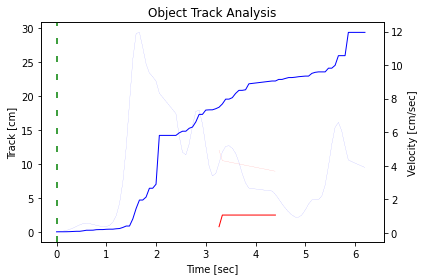

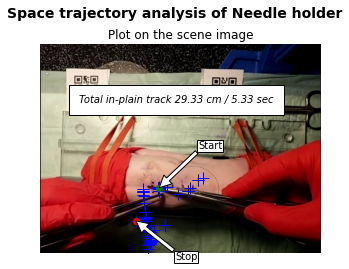

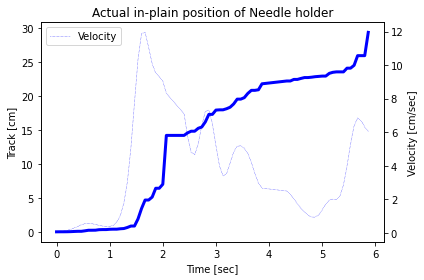

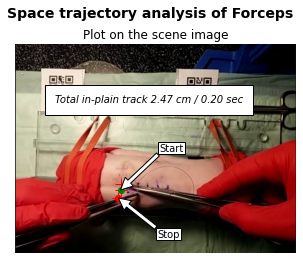

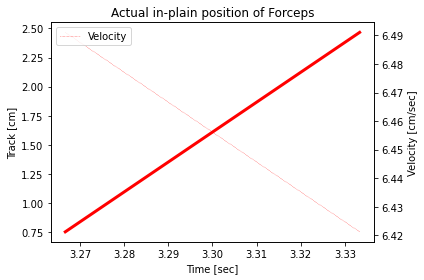

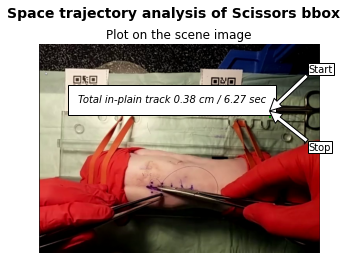

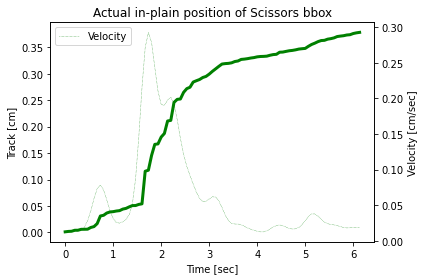

In [15]:
dcv = pigleg_cv.DoComputerVision(
    mediafile_path,
    outputdir,
    test_first_seconds=test_first_seconds,
    is_microsurgery=is_microsurgery,
    force_tracker=force_tracker
)
dcv.run()

In [16]:
logger

<loguru.logger handlers=[]>

In [17]:
from loguru import logger
logger.debug("ahoj")

In [18]:
logger.warning("asdf")

In [19]:
# report_data = dcv.make_report()